In [8]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import math
import pandas as pd

In [9]:
def filter_non_digits(string):
    result = ''
    for char in string:
        if char in '1234567890':
            result += char
    return result 

In [10]:
def remove_low(f):
    song, sr = librosa.load(f)
    D = np.abs(librosa.stft(song))
    #FIND OUT HOW MANY FREQUENCIES WE REMOVED HERE! About 10.7*64, 10.7 is the value of librosa.fft_frequencies()[1] 
    D=D[64:]
    DB = librosa.amplitude_to_db(D, ref=np.max)
    return DB

def remove_talking_and_low(f):
    chirp_song, sr = librosa.load(f)
    split=librosa.effects.split(chirp_song, top_db=60)
    chirp_song_split=chirp_song[split[1,0]:split[1,1]]
    if chirp_song_split.shape[0] > 220500:
        chirp_song_split = chirp_song_split[:220500]
    D = np.abs(librosa.stft(chirp_song_split))
    #FIND OUT HOW MANY FREQUENCIES WE REMOVED HERE!
    D=D[64:]
    DB = librosa.amplitude_to_db(D, ref=np.max)
    return DB

In [11]:
def compute_var(DB):
    variance = np.zeros(DB.shape[0])
    for x in range(0,DB.shape[0]):
        variance[x] = np.var(DB[x,:])
    return variance

In [19]:
def main_freq_and_range(f, remove_talk, sound_range = .5):
    if remove_talk:
        variance = compute_var(remove_talking_and_low(f))
    else:
        variance = compute_var(remove_low(f))
    maxfreq = np.argmax(variance)
    maxvar = max(variance)
    if variance[maxfreq] != maxvar:
        print ('failed! at file ', f)
        return None

    #find range of frequencies around the max freq where the animal is loud 
    min_freq_range = 0
    max_freq_range = 0
    i=0
    bool_high =True
    bool_low = True
    while bool_high or bool_low:
        if bool_high:
            if maxfreq+i>len(variance)-1:
                max_freq_range = maxfreq+i
                bool_high = False
            elif variance[maxfreq+i] < sound_range*maxvar:
                #print ('max freq range =', (maxfreq+i+64)*librosa.fft_frequencies()[1])
                max_freq_range = maxfreq+i
                bool_high = False
        if bool_low:
            if maxfreq-i<0:
                min_freq_range = 0
                bool_low = False
            elif variance[maxfreq-i] < sound_range*maxvar:
                #print ('min freq range =', (maxfreq-i+64)*librosa.fft_frequencies()[1])
                min_freq_range = maxfreq-i
                bool_low = False
        i = i+1
    size = (max_freq_range+64)/(min_freq_range+64)
    return (maxfreq+64)*librosa.fft_frequencies()[1], size

def main_freq_and_back_freq(f, cutoff):
    song, sr = librosa.load(f)
    D = np.abs(librosa.stft(song))
    cut = int(float(cutoff)/(librosa.fft_frequencies()[1]))
    D = D[cut:]
    DB = librosa.amplitude_to_db(D, ref=np.max)
    maxmean = np.mean(DB[0,:])
    backfreq = 0
    maxvar = np.var(DB[0,:])
    maxfreq = 0
    for x in range(1,DB.shape[0]):
        mean = np.mean(DB[x,:])
        var = np.var(DB[x,:])
        if mean > maxmean:
            maxmean = mean
            backfreq = x
        if var > maxvar:
            maxvar = var
            maxfreq = x
    return maxfreq * librosa.fft_frequencies()[1],backfreq * librosa.fft_frequencies()[1]

def main_freq(song, cutoff = 800):
    D = np.abs(librosa.stft(song))
    cut = int(float(cutoff)/(librosa.fft_frequencies()[1]))
    D = D[cut:]
    DB = librosa.amplitude_to_db(D, ref=np.max)
    maxmean = np.mean(DB[0,:])
    main_meanfreq = 0
    maxvar = np.var(DB[0,:])
    main_varfreq = 0
    for x in range(1,DB.shape[0]):
        mean = np.mean(DB[x,:])
        var = np.var(DB[x,:])
        if mean > maxmean:
            maxmean = mean
            main_meanfreq = x
        if var > maxvar:
            maxvar = var
            main_varfreq = x
    return main_varfreq * librosa.fft_frequencies()[1], main_meanfreq * librosa.fft_frequencies()[1]

In [20]:
#No need to run
no_voice_list = pd.read_csv('no_voice_files.csv', header=None)
filename_list = [name.split("\\")[-1] for name in no_voice_list[0]]

In [21]:
df = pd.read_csv('MLNS_Insects_Fams_05212024.csv')

In [23]:
ct = 0
for name in filename_list:
    #change this file path to the chirp_bucket_2 folder
    file_path = '../../../chirp/'+name
   # song, sr = librosa.load(file_path)
   # if True song.shape[0] > sr/2:
    if True:
        tester = main_freq_and_range(file_path, remove_talk=False, sound_range = .5)
        song, sr = librosa.load(file_path)
        tester1 = main_freq(song)
        ct+=1
        df.at[df.loc[df['cat_num']==int(name[:-4])].index[0], 'main_freq'] = tester[0]
        df.at[df.loc[df['cat_num']==int(name[:-4])].index[0], 'range'] = tester[1]
        df.at[df.loc[df['cat_num']==int(name[:-4])].index[0], 'max_mean'] = tester1[1]
        ct+=1
        if ct % 100 == 0:
            df.to_csv("MLNS_with_main_freq_and_range_05272024.csv")
            print(f'Did {ct}')

/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1250
  warnings.warn(
/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1680
  warnings.warn(
/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1814
  warnings.warn(
/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1208
  warnings.warn(
/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWar

Did 100
Did 200


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(
/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1536
  warnings.warn(


Did 300
Did 400
Did 500
Did 600
Did 700
Did 800
Did 900
Did 1000
Did 1100
Did 1200
Did 1300
Did 1400
Did 1500
Did 1600
Did 1700
Did 1800
Did 1900
Did 2000
Did 2100
Did 2200
Did 2300
Did 2400
Did 2500
Did 2600
Did 2700
Did 2800
Did 2900
Did 3000
Did 3100
Did 3200
Did 3300
Did 3400
Did 3500
Did 3600
Did 3700
Did 3800
Did 3900
Did 4000
Did 4100
Did 4200
Did 4300
Did 4400
Did 4500
Did 4600
Did 4700
Did 4800
Did 4900
Did 5000
Did 5100
Did 5200
Did 5300
Did 5400
Did 5500
Did 5600
Did 5700
Did 5800
Did 5900
Did 6000
Did 6100
Did 6200
Did 6300
Did 6400
Did 6500
Did 6600
Did 6700
Did 6800
Did 6900
Did 7000
Did 7100
Did 7200
Did 7300
Did 7400
Did 7500
Did 7600
Did 7700
Did 7800
Did 7900
Did 8000
Did 8100
Did 8200
Did 8300
Did 8400
Did 8500
Did 8600
Did 8700
Did 8800
Did 8900
Did 9000
Did 9100
Did 9200
Did 9300
Did 9400
Did 9500
Did 9600
Did 9700
Did 9800
Did 9900
Did 10000
Did 10100
Did 10200
Did 10300
Did 10400
Did 10500
Did 10600
Did 10700
Did 10800
Did 10900
Did 11000
Did 11100
Did 11200
Did 

In [ ]:
        
        lib = librosa.feature.mfcc(y=song, sr=sr, fmin = 800, n_mfcc=n)
        for i in range(0,n):
            df.at[df.loc[df['cat_num']==int(name[:-4])].index[0], 'mfcc_'+str(i)+'_avg'] = lib[i].mean()
            df.at[df.loc[df['cat_num']==int(name[:-4])].index[0], 'mfcc_'+str(i)+'_var'] = lib[i].var()
           # df['mfcc_'+str(i)+'_avg']=lib[i].mean()
           # df['mfcc_'+str(i)+'_var']=lib[i].var()
        ct+=1
        if ct % 100 == 0:
            df.to_csv("MLNS_with_mfcc_stats_800_cutoff_05272024.csv")

In [6]:
def plot_specto(f):
    song,sr = librosa.load(f)
    hop_length = 1024
    n_fft = 2048
    D = np.abs(librosa.stft(song, n_fft=n_fft,  hop_length=hop_length))
    DB = librosa.amplitude_to_db(D, ref=np.max)
    librosa.display.specshow(DB, hop_length=hop_length, x_axis='time', y_axis='log');
    plt.colorbar(format='%+2.0f dB');
    plt.show()
    return None

In [7]:
def get_freq_and_range(directory, remove_talk = False, plot = False, sound_range=.5):
    df = pd.read_csv('MLNS_Insects_fams_05212024.csv')
    out = pd.DataFrame(columns = ['critter_name','main_frequency','range'])
    i = 0
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        i=i+1
        if i%100 == 0:
            print (100*i/len(os.listdir(directory)),' percent done')
        if os.path.isfile(f):
            #recover type
            file_name = float(filter_non_digits(f))
            critter_name = df.loc[df.cat_num==file_name].critter_name
            
            #recover main freq and range
            freq, rang = main_freq_and_range(f, remove_talk, sound_range = sound_range)
            new_row = pd.DataFrame({'critter_name': critter_name, 'main_frequency': freq, 'range': rang})
            out = pd.concat([out, new_row])
    return out
    
def get_main_freq_and_background_freq(dictionary, cutoff = 800):
    df = pd.read_csv('MLNS_Insects_fams_05212024.csv')
    out = pd.DataFrame(columns = ['critter_name','main_frequency','background_frequency'])
    i = 0
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        i=i+1
        if i%100 == 0:
            print (100*i/len(os.listdir(directory)),' percent done')
        if os.path.isfile(f):
            #recover type
            file_name = float(filter_non_digits(f))
            critter_name = df.loc[df.cat_num==file_name].critter_name
            
            #recover main freq and range
            freq, back_freq = main_freq_and_back_freq(f, cutoff)
            new_row = pd.DataFrame({'critter_name': critter_name, 'main_frequency': freq, 'background_frequency': back_freq})
            out = pd.concat([out, new_row])
    print (100, ' percent done ')
    return out


def sanity_check(directory, plot = False, remove_talk = False, sound_range = .5):
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            #recover main freq and range
            print (main_freq_and_range(f,remove_talk, sound_range = sound_range))
            plot_specto(f)
    return out

/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_75704/667413292.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat([out, new_row])
/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


0.016337199803953602  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1250
  warnings.warn(
/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1536
  warnings.warn(


0.032674399607907204  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1680
  warnings.warn(


0.049011599411860805  percent done
0.06534879921581441  percent done
0.08168599901976802  percent done
0.09802319882372161  percent done
0.11436039862767522  percent done
0.13069759843162881  percent done
0.1470347982355824  percent done
0.16337199803953603  percent done
0.17970919784348963  percent done
0.19604639764744322  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


0.21238359745139684  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1814
  warnings.warn(


0.22872079725535044  percent done
0.24505799705930403  percent done
0.26139519686325763  percent done
0.2777323966672112  percent done
0.2940695964711648  percent done
0.31040679627511847  percent done
0.32674399607907206  percent done
0.34308119588302566  percent done
0.35941839568697925  percent done
0.37575559549093285  percent done
0.39209279529488644  percent done
0.40842999509884004  percent done
0.4247671949027937  percent done
0.4411043947067473  percent done
0.4574415945107009  percent done
0.47377879431465447  percent done
0.49011599411860807  percent done
0.5064531939225617  percent done
0.5227903937265153  percent done
0.5391275935304689  percent done
0.5554647933344224  percent done
0.5718019931383761  percent done
0.5881391929423296  percent done
0.6044763927462833  percent done
0.6208135925502369  percent done
0.6371507923541905  percent done
0.6534879921581441  percent done
0.6698251919620977  percent done
0.6861623917660513  percent done
0.7024995915700049  percent don

/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1293
  warnings.warn(


0.7841855905897729  percent done
0.8005227903937265  percent done
0.8168599901976801  percent done
0.8331971900016337  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1208
  warnings.warn(


0.8495343898055874  percent done
0.8658715896095409  percent done
0.8822087894134946  percent done
0.8985459892174481  percent done
0.9148831890214018  percent done
0.9312203888253553  percent done
0.9475575886293089  percent done
0.9638947884332625  percent done
0.9802319882372161  percent done
0.9965691880411698  percent done


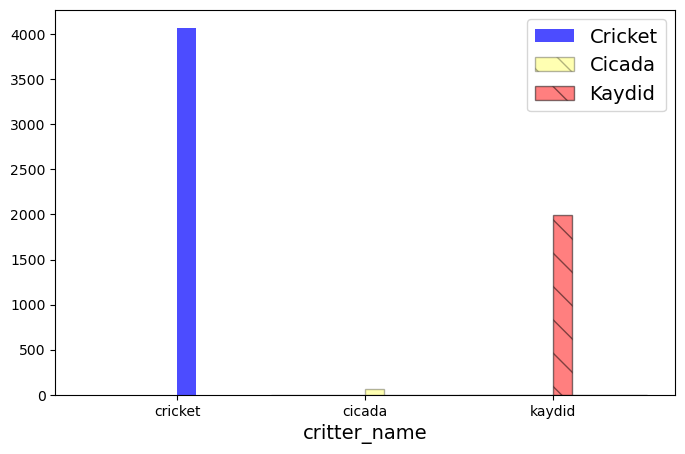

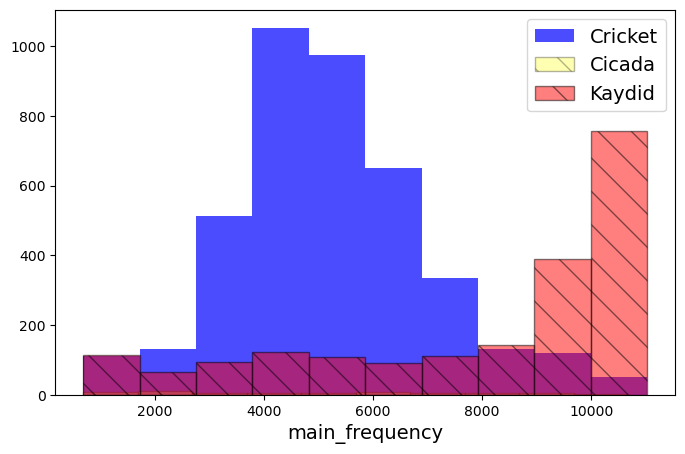

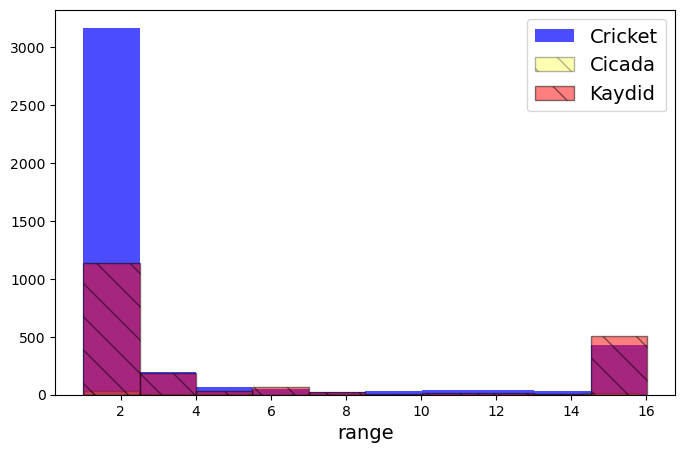

In [24]:
directory = '/Users/calvinyost-wolff/Documents/GitHub/chirpfiles/NoTalk'

data = get_freq_and_range(directory, plot = False, remove_talk = False, sound_range = .5)
for col in data.columns:
    plt.figure(figsize=(8,5))


    plt.hist(data.loc[data.critter_name=='cricket', col].values,
                color='blue',
                alpha=.7,
                label="Cricket")

    plt.hist(data.loc[data.critter_name=='cicada', col].values,
                color='yellow',
                alpha=.3,
                hatch = '\\',
                edgecolor='black',
                label="Cicada")

    plt.hist(data.loc[data.critter_name=='kaydid', col].values,
            color='red',
            alpha=.5,
            hatch = '\\',
            edgecolor='black',
            label="Kaydid")

    plt.xlabel(col, fontsize=14)
    plt.legend(fontsize=14)

    plt.show()

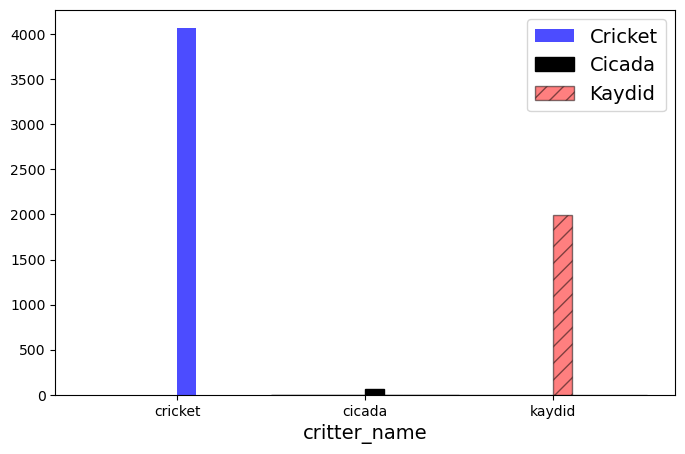

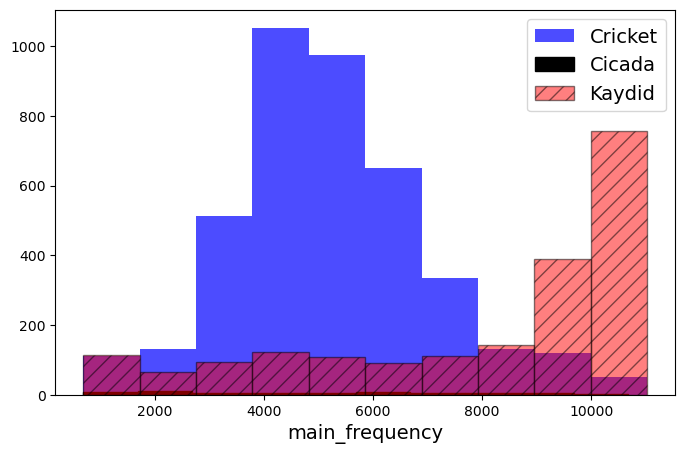

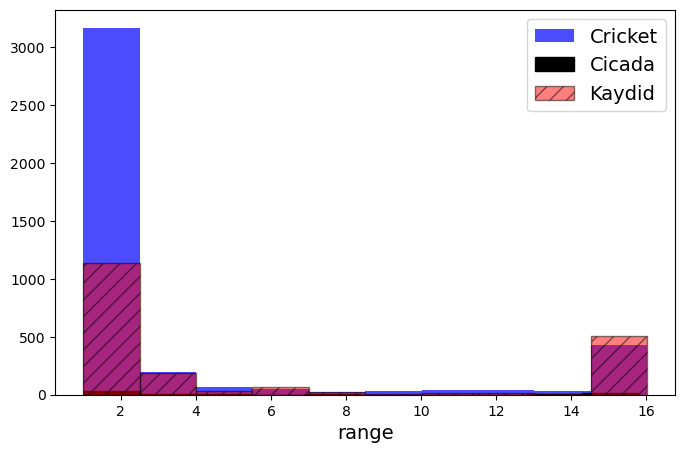

In [25]:
for col in data.columns:
    plt.figure(figsize=(8,5))


    plt.hist(data.loc[data.critter_name=='cricket', col].values,
                color='blue',
                alpha=.7,
                label="Cricket")

    plt.hist(data.loc[data.critter_name=='cicada', col].values,
                color='black',
                alpha=1,
                hatch = '\\',
                edgecolor='black',
                label="Cicada")

    plt.hist(data.loc[data.critter_name=='kaydid', col].values,
            color='red',
            alpha=.5,
            hatch = '//',
            edgecolor='black',
            label="Kaydid")

    plt.xlabel(col, fontsize=14)
    plt.legend(fontsize=14)

    plt.show()

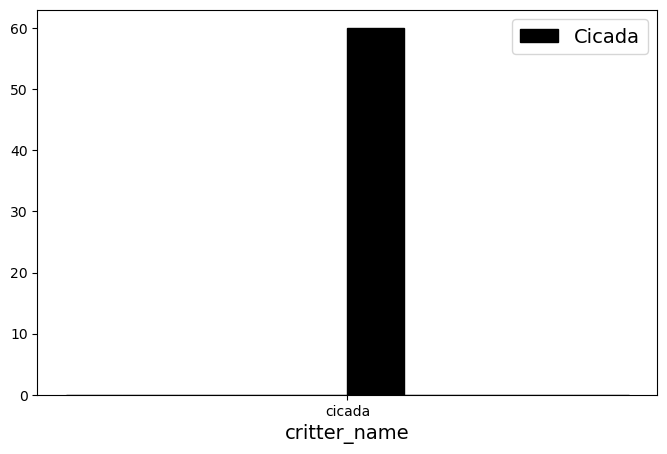

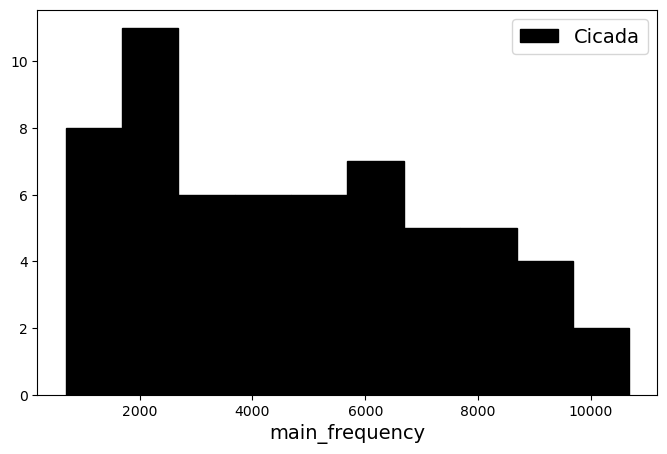

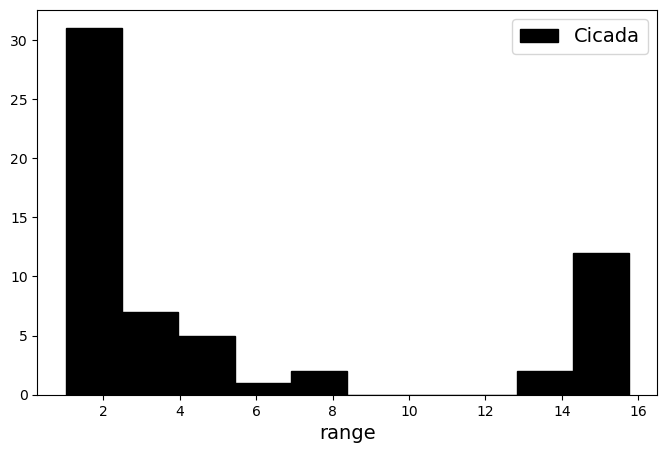

In [26]:
for col in data.columns:
    plt.figure(figsize=(8,5))


    plt.hist(data.loc[data.critter_name=='cicada', col].values,
                color='black',
                alpha=1,
                hatch = '\\',
                edgecolor='black',
                label="Cicada")
    
    plt.xlabel(col, fontsize=14)
    plt.legend(fontsize=14)
    
    plt.show()

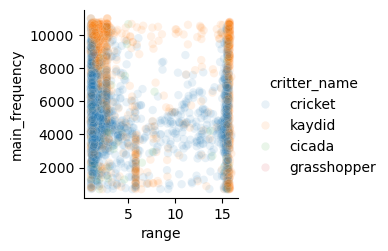

In [27]:
import seaborn as sns
sns.pairplot(data = data,
                x_vars = ['range'],
                y_vars = ['main_frequency'],
                hue = 'critter_name',
                plot_kws = {'alpha':.1})

plt.show()

In [13]:
directory = '/Users/calvinyost-wolff/Documents/GitHub/chirpfiles/NoTalk'

data = get_main_freq_and_background_freq(directory)

/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_34405/217172462.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat([out, new_row])
/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1.6337199803953601  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1250
  warnings.warn(
/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1536
  warnings.warn(


3.2674399607907203  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1680
  warnings.warn(


4.901159941186081  percent done
6.534879921581441  percent done
8.168599901976801  percent done
9.802319882372162  percent done
11.436039862767522  percent done
13.069759843162881  percent done
14.703479823558242  percent done
16.337199803953602  percent done
17.97091978434896  percent done
19.604639764744324  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


21.238359745139682  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1814
  warnings.warn(


22.872079725535045  percent done
24.505799705930404  percent done
26.139519686325762  percent done
27.773239666721125  percent done
29.406959647116484  percent done
31.040679627511846  percent done
32.674399607907205  percent done
34.30811958830257  percent done
35.94183956869792  percent done
37.575559549093285  percent done
39.20927952948865  percent done
40.842999509884  percent done
42.476719490279365  percent done
44.11043947067473  percent done
45.74415945107009  percent done
47.377879431465445  percent done
49.01159941186081  percent done
50.64531939225617  percent done
52.279039372651525  percent done
53.91275935304689  percent done
55.54647933344225  percent done
57.180199313837605  percent done
58.81391929423297  percent done
60.44763927462833  percent done
62.08135925502369  percent done
63.71507923541905  percent done
65.34879921581441  percent done
66.98251919620976  percent done
68.61623917660513  percent done
70.24995915700049  percent done
71.88367913739584  percent don

/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1293
  warnings.warn(


78.4185590589773  percent done
80.05227903937265  percent done
81.685999019768  percent done
83.31971900016337  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1208
  warnings.warn(


84.95343898055873  percent done
86.5871589609541  percent done
88.22087894134945  percent done
89.85459892174481  percent done
91.48831890214018  percent done
93.12203888253553  percent done
94.75575886293089  percent done
96.38947884332626  percent done
98.02319882372161  percent done
99.65691880411697  percent done


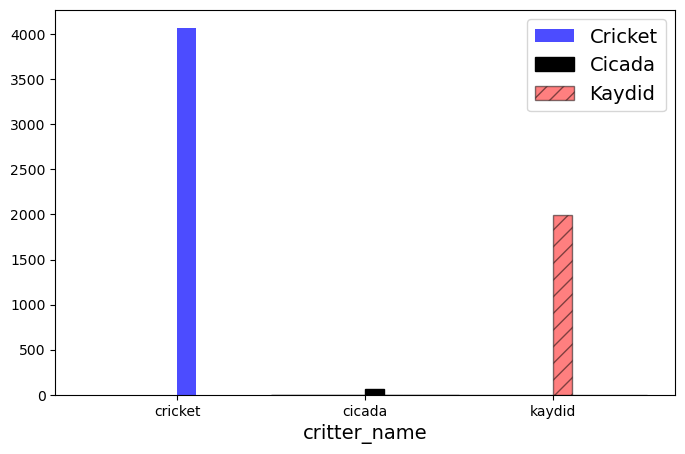

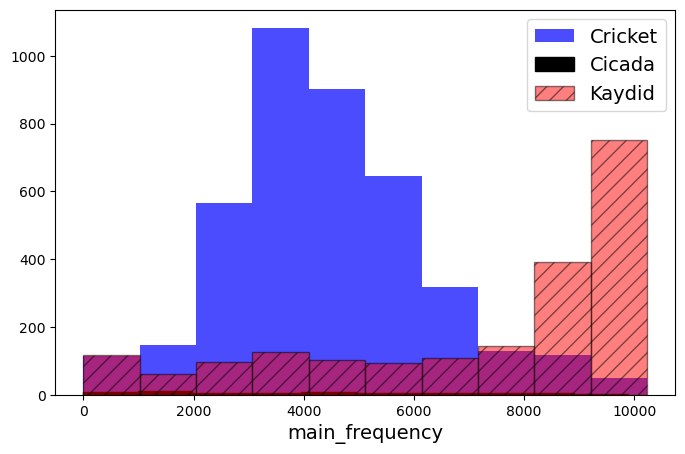

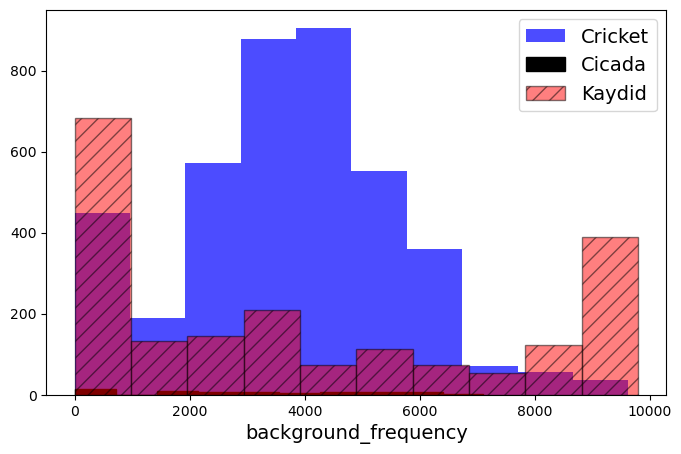

In [15]:
for col in data.columns:
    plt.figure(figsize=(8,5))


    plt.hist(data.loc[data.critter_name=='cricket', col].values,
                color='blue',
                alpha=.7,
                label="Cricket")

    plt.hist(data.loc[data.critter_name=='cicada', col].values,
                color='black',
                alpha=1,
                hatch = '\\',
                edgecolor='black',
                label="Cicada")

    plt.hist(data.loc[data.critter_name=='kaydid', col].values,
            color='red',
            alpha=.5,
            hatch = '//',
            edgecolor='black',
            label="Kaydid")

    plt.xlabel(col, fontsize=14)
    plt.legend(fontsize=14)

    plt.show()

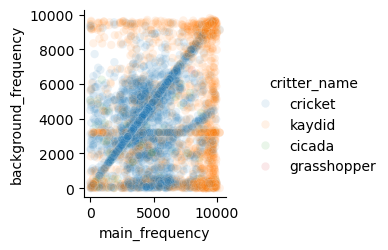

In [16]:
import seaborn as sns
sns.pairplot(data = data,
                x_vars = ['main_frequency'],
                y_vars = ['background_frequency'],
                hue = 'critter_name',
                plot_kws = {'alpha':.1})

plt.show()

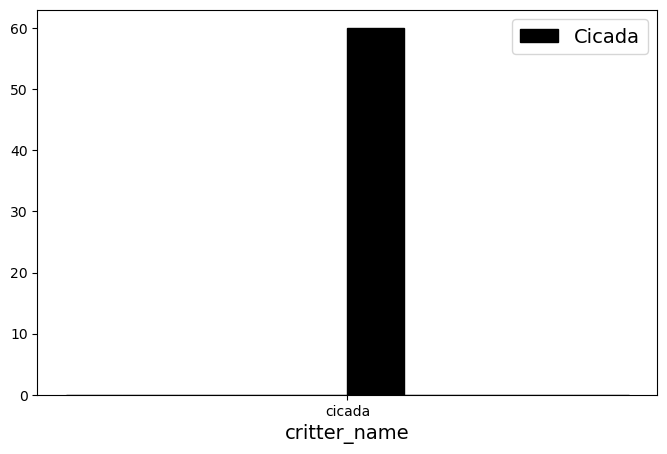

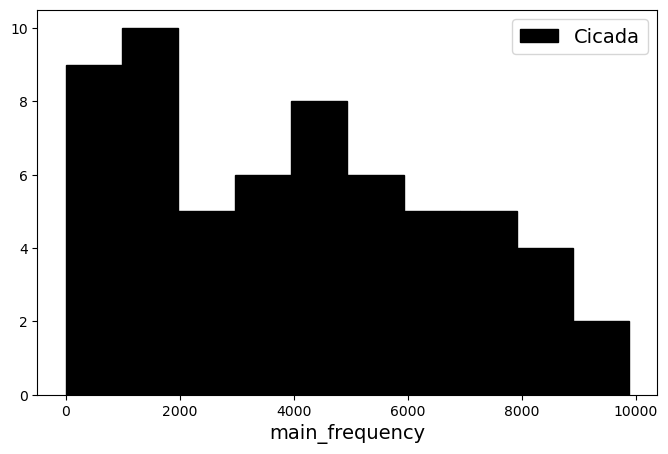

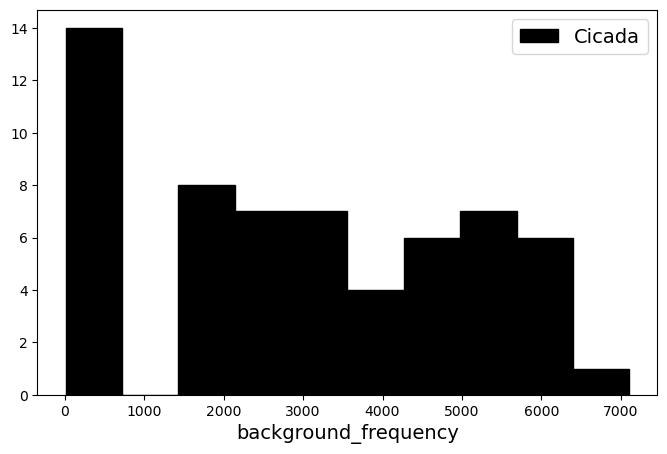

In [17]:
for col in data.columns:
    plt.figure(figsize=(8,5))


    plt.hist(data.loc[data.critter_name=='cicada', col].values,
                color='black',
                alpha=1,
                hatch = '\\',
                edgecolor='black',
                label="Cicada")
    
    plt.xlabel(col, fontsize=14)
    plt.legend(fontsize=14)
    
    plt.show()

In [19]:
int(float(800)/(librosa.fft_frequencies()[1]))

74

In [20]:
directory = '/Users/calvinyost-wolff/Documents/GitHub/chirpfiles/NoTalk'

data = get_main_freq_and_background_freq(directory, cutoff = 0)

/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_34405/3799050981.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat([out, new_row])
/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1.6337199803953601  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1250
  warnings.warn(
/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1536
  warnings.warn(


3.2674399607907203  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1680
  warnings.warn(


4.901159941186081  percent done
6.534879921581441  percent done
8.168599901976801  percent done
9.802319882372162  percent done
11.436039862767522  percent done
13.069759843162881  percent done
14.703479823558242  percent done
16.337199803953602  percent done
17.97091978434896  percent done
19.604639764744324  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


21.238359745139682  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1814
  warnings.warn(


22.872079725535045  percent done
24.505799705930404  percent done
26.139519686325762  percent done
27.773239666721125  percent done
29.406959647116484  percent done
31.040679627511846  percent done
32.674399607907205  percent done
34.30811958830257  percent done
35.94183956869792  percent done
37.575559549093285  percent done
39.20927952948865  percent done
40.842999509884  percent done
42.476719490279365  percent done
44.11043947067473  percent done
45.74415945107009  percent done
47.377879431465445  percent done
49.01159941186081  percent done
50.64531939225617  percent done
52.279039372651525  percent done
53.91275935304689  percent done
55.54647933344225  percent done
57.180199313837605  percent done
58.81391929423297  percent done
60.44763927462833  percent done
62.08135925502369  percent done
63.71507923541905  percent done
65.34879921581441  percent done
66.98251919620976  percent done
68.61623917660513  percent done
70.24995915700049  percent done
71.88367913739584  percent don

/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1293
  warnings.warn(


78.4185590589773  percent done
80.05227903937265  percent done
81.685999019768  percent done
83.31971900016337  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1208
  warnings.warn(


84.95343898055873  percent done
86.5871589609541  percent done
88.22087894134945  percent done
89.85459892174481  percent done
91.48831890214018  percent done
93.12203888253553  percent done
94.75575886293089  percent done
96.38947884332626  percent done
98.02319882372161  percent done
99.65691880411697  percent done
100  percent done 


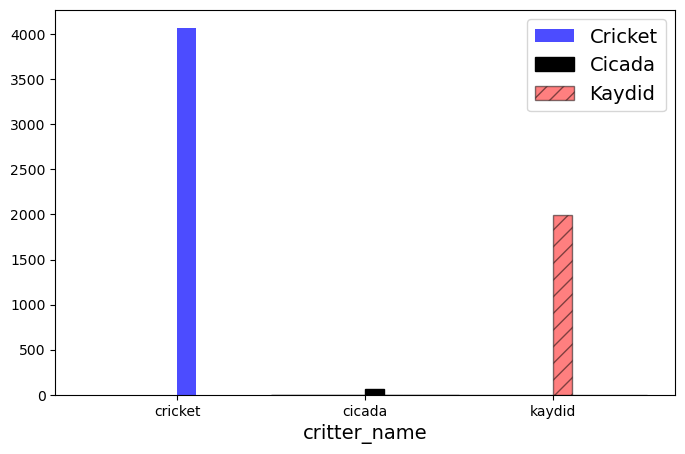

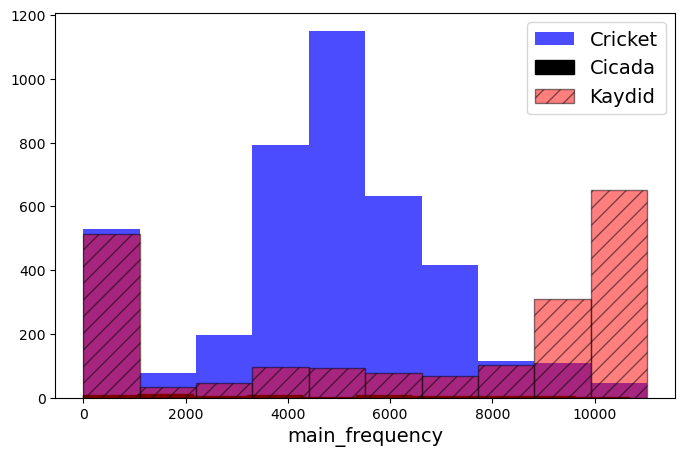

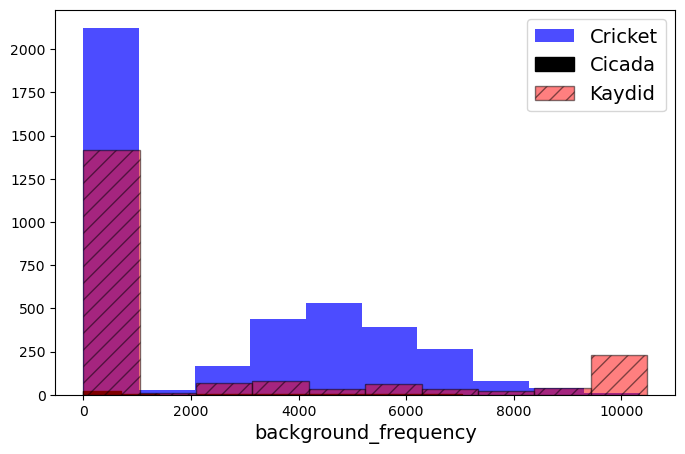

In [21]:
for col in data.columns:
    plt.figure(figsize=(8,5))


    plt.hist(data.loc[data.critter_name=='cricket', col].values,
                color='blue',
                alpha=.7,
                label="Cricket")

    plt.hist(data.loc[data.critter_name=='cicada', col].values,
                color='black',
                alpha=1,
                hatch = '\\',
                edgecolor='black',
                label="Cicada")

    plt.hist(data.loc[data.critter_name=='kaydid', col].values,
            color='red',
            alpha=.5,
            hatch = '//',
            edgecolor='black',
            label="Kaydid")

    plt.xlabel(col, fontsize=14)
    plt.legend(fontsize=14)

    plt.show()

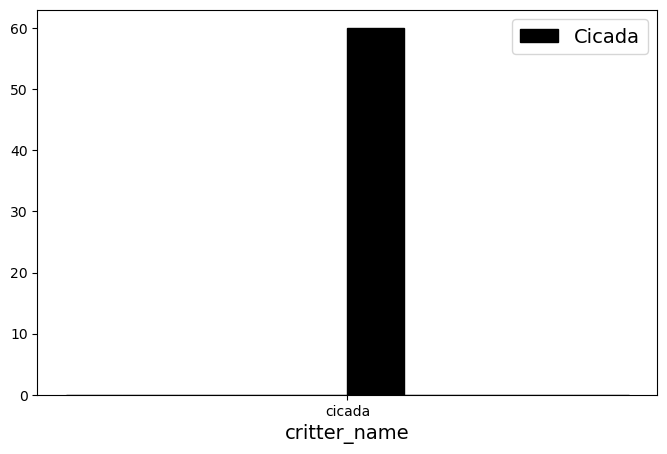

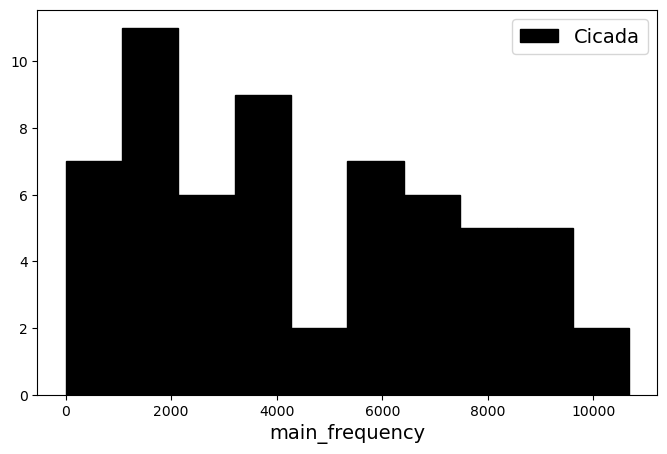

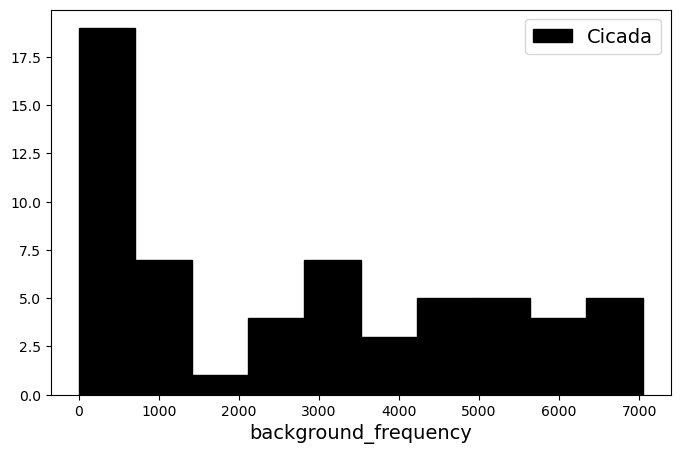

In [22]:
for col in data.columns:
    plt.figure(figsize=(8,5))


    plt.hist(data.loc[data.critter_name=='cicada', col].values,
                color='black',
                alpha=1,
                hatch = '\\',
                edgecolor='black',
                label="Cicada")
    
    plt.xlabel(col, fontsize=14)
    plt.legend(fontsize=14)
    
    plt.show()